In [1]:
# Cek dan aktifkan GPU jika tersedia
import tensorflow as tf
import torch

# Cek TensorFlow
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Cek PyTorch
print("PyTorch version:", torch.__version__)
print("CUDA Available: ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device Name:", torch.cuda.get_device_name(0))

TensorFlow version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PyTorch version: 2.6.0+cu124
CUDA Available:  True
GPU Device Name: Tesla T4


In [2]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import nltk
from nltk.corpus import stopwords
import re
import string
import time
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

# Download resource untuk NLP
!pip install nltk
nltk.download('punkt')
nltk.download('stopwords')

# Set random seed untuk reproducibility
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import files
uploaded = files.upload()

# Jika sudah di-upload sebelumnya, bisa skip cell ini dan langsung load dataset

Saving ReviewTokoBaju.csv to ReviewTokoBaju (1).csv


In [4]:
# Load dataset
df = pd.read_csv('ReviewTokoBaju.csv')

# Melihat informasi dataset
print(f"Dataset shape: {df.shape}")
print("\nInformasi Dataset:")
df.info()

Dataset shape: (23486, 11)

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [5]:
# Melihat beberapa baris pertama
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [6]:
# Statistik deskriptif
df.describe(include='all')

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
count,23486.000000,23486.000000,23486.000000,19676,22641,23486.000000,23486.000000,23486.000000,23472,23472,23472
unique,NaN,NaN,NaN,13993,22634,NaN,NaN,NaN,3,6,20
top,NaN,NaN,NaN,Love it!,Perfect fit and i've gotten so many compliment...,NaN,NaN,NaN,General,Tops,Dresses
freq,NaN,NaN,NaN,136,3,NaN,NaN,NaN,13850,10468,6319
mean,11742.500000,918.118709,43.198544,NaN,NaN,4.196032,0.822362,2.535936,NaN,NaN,NaN
std,6779.968547,203.298980,12.279544,NaN,NaN,1.110031,0.382216,5.702202,NaN,NaN,NaN
min,0.000000,0.000000,18.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN
25%,5871.250000,861.000000,34.000000,NaN,NaN,4.000000,1.000000,0.000000,NaN,NaN,NaN
50%,11742.500000,936.000000,41.000000,NaN,NaN,5.000000,1.000000,1.000000,NaN,NaN,NaN
75%,17613.750000,1078.000000,52.000000,NaN,NaN,5.000000,1.000000,3.000000,NaN,NaN,NaN


In [7]:
# Periksa nilai yang hilang
missing_values = df.isnull().sum()
print("Jumlah nilai yang hilang per kolom:")
print(missing_values[missing_values > 0])

Jumlah nilai yang hilang per kolom:
Title              3810
Review Text         845
Division Name        14
Department Name      14
Class Name           14
dtype: int64


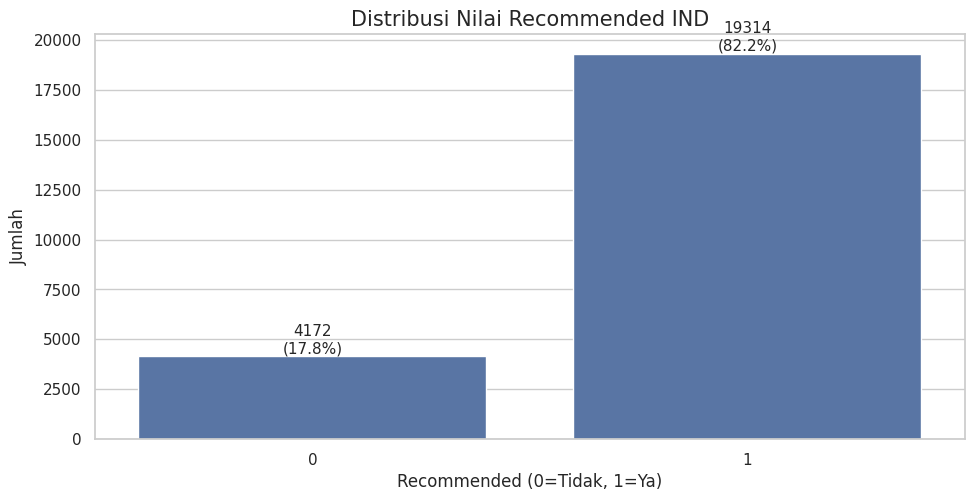

Persentase distribusi target:
Recommended IND
1    82.236226
0    17.763774
Name: proportion, dtype: float64


In [8]:
# Distribusi target (Recommended IND)
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Recommended IND', data=df)
plt.title('Distribusi Nilai Recommended IND', fontsize=15)
plt.xlabel('Recommended (0=Tidak, 1=Ya)', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)

# Tambahkan anotasi jumlah
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{int(p.get_height())}\n({percentage})', (x, y),
                ha='center', va='bottom', fontsize=11)

plt.show()

# Tampilkan persentase dalam tabel
recommended_counts = df['Recommended IND'].value_counts(normalize=True) * 100
print("Persentase distribusi target:")
print(recommended_counts)

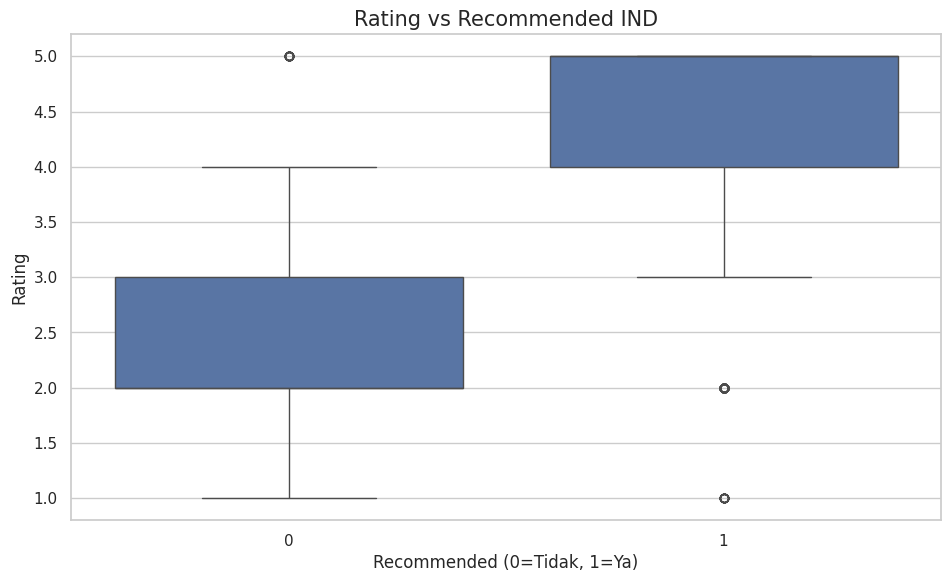

Rata-rata rating berdasarkan rekomendasi:
Recommended IND
0    2.303691
1    4.604794
Name: Rating, dtype: float64


In [9]:
# Hubungan antara Rating dan Recommended IND
plt.figure(figsize=(10, 6))
sns.boxplot(x='Recommended IND', y='Rating', data=df)
plt.title('Rating vs Recommended IND', fontsize=15)
plt.xlabel('Recommended (0=Tidak, 1=Ya)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()

# Tabel rata-rata rating berdasarkan rekomendasi
rating_by_recommendation = df.groupby('Recommended IND')['Rating'].mean()
print("Rata-rata rating berdasarkan rekomendasi:")
print(rating_by_recommendation)

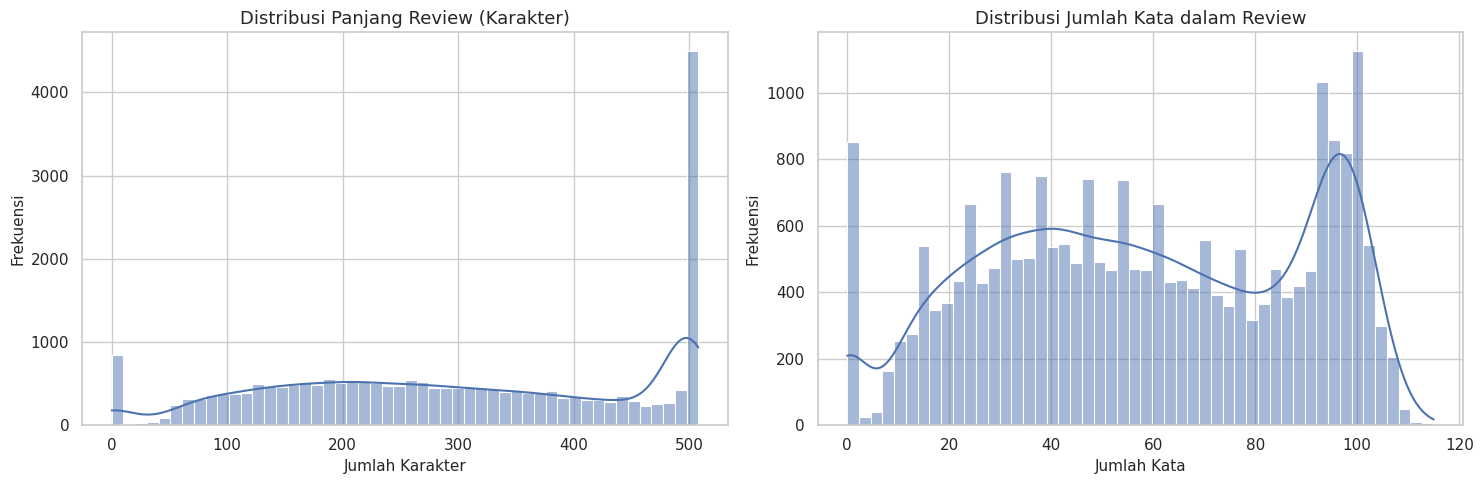

Statistik panjang review (karakter):
count    23486.000000
mean       297.581666
std        152.572686
min          0.000000
25%        173.000000
50%        292.000000
75%        451.000000
max        508.000000
Name: Review Length, dtype: float64

Statistik jumlah kata dalam review:
count    23486.000000
mean        58.030869
std         30.176433
min          0.000000
25%         34.000000
50%         57.000000
75%         87.000000
max        115.000000
Name: Word Count, dtype: float64


In [10]:
# Analisis panjang review
df['Review Length'] = df['Review Text'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
df['Word Count'] = df['Review Text'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Distribusi panjang karakter
sns.histplot(df['Review Length'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Distribusi Panjang Review (Karakter)', fontsize=13)
ax[0].set_xlabel('Jumlah Karakter', fontsize=11)
ax[0].set_ylabel('Frekuensi', fontsize=11)

# Distribusi jumlah kata
sns.histplot(df['Word Count'], bins=50, kde=True, ax=ax[1])
ax[1].set_title('Distribusi Jumlah Kata dalam Review', fontsize=13)
ax[1].set_xlabel('Jumlah Kata', fontsize=11)
ax[1].set_ylabel('Frekuensi', fontsize=11)

plt.tight_layout()
plt.show()

# Statistik panjang review
print("Statistik panjang review (karakter):")
print(df['Review Length'].describe())

print("\nStatistik jumlah kata dalam review:")
print(df['Word Count'].describe())

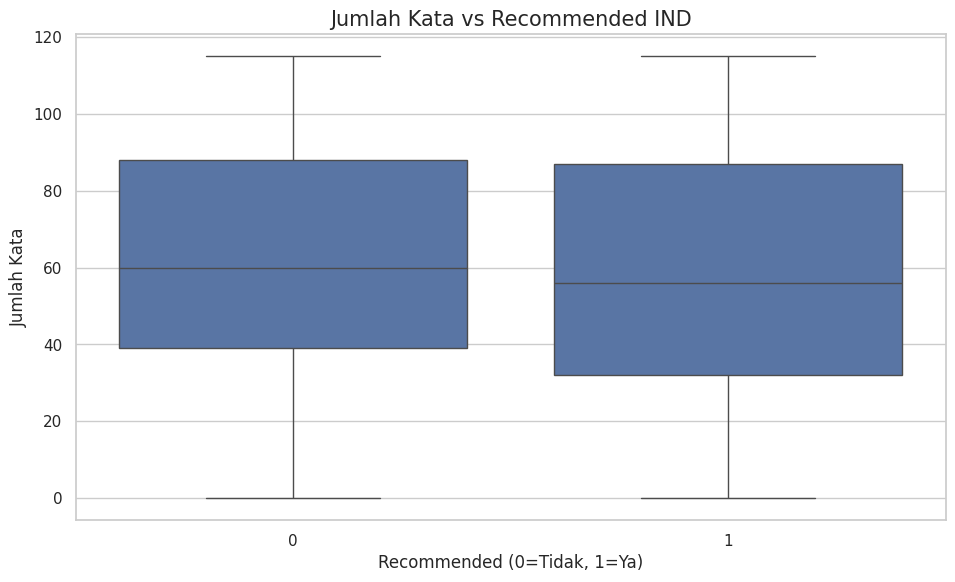

Rata-rata jumlah kata berdasarkan rekomendasi:
Recommended IND
0    60.946788
1    57.401004
Name: Word Count, dtype: float64


In [11]:
# Panjang review berdasarkan rekomendasi
plt.figure(figsize=(10, 6))
sns.boxplot(x='Recommended IND', y='Word Count', data=df)
plt.title('Jumlah Kata vs Recommended IND', fontsize=15)
plt.xlabel('Recommended (0=Tidak, 1=Ya)', fontsize=12)
plt.ylabel('Jumlah Kata', fontsize=12)
plt.show()

# Rata-rata jumlah kata berdasarkan rekomendasi
words_by_recommendation = df.groupby('Recommended IND')['Word Count'].mean()
print("Rata-rata jumlah kata berdasarkan rekomendasi:")
print(words_by_recommendation)

In [12]:
# Fungsi untuk preprocessing teks
def preprocess_text(text):
    # Tangani nilai NaN
    if pd.isna(text):
        return ""

    # Konversi ke lowercase
    text = text.lower()

    # Hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Hapus angka
    text = re.sub(r'\d+', '', text)

    # Hapus whitespace berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Terapkan preprocessing pada kolom Review Text
print("Menerapkan preprocessing pada teks review...")
df['Processed Review'] = df['Review Text'].apply(preprocess_text)

# Tampilkan contoh hasil preprocessing
print("\nContoh hasil preprocessing:")
for i in range(3):
    print(f"\nOriginal: {df['Review Text'].iloc[i][:100]}...")
    print(f"Processed: {df['Processed Review'].iloc[i][:100]}...")

Menerapkan preprocessing pada teks review...

Contoh hasil preprocessing:

Original: Absolutely wonderful - silky and sexy and comfortable...
Processed: absolutely wonderful silky and sexy and comfortable...

Original: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never...
Processed: love this dress its sooo pretty i happened to find it in a store and im glad i did bc i never would ...

Original: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the pe...
Processed: i had such high hopes for this dress and really wanted it to work for me i initially ordered the pet...


In [13]:
# Pemisahan data training dan testing
X = df['Processed Review']
y = df['Recommended IND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Jumlah sampel training: {X_train.shape[0]}")
print(f"Jumlah sampel testing: {X_test.shape[0]}")
print(f"Distribusi kelas di training set: {y_train.value_counts().to_dict()}")
print(f"Distribusi kelas di testing set: {y_test.value_counts().to_dict()}")

Jumlah sampel training: 18788
Jumlah sampel testing: 4698
Distribusi kelas di training set: {1: 15451, 0: 3337}
Distribusi kelas di testing set: {1: 3863, 0: 835}


In [14]:
# Tokenisasi dan pembuatan kamus kata
from collections import Counter

def build_vocab(texts, max_vocab_size=10000):
    # Gabungkan semua teks dan hitung frekuensi kata
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)

    # Ambil kata-kata yang paling sering muncul
    most_common = word_counts.most_common(max_vocab_size - 2)  # -2 untuk token khusus

    # Buat kamus kata
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in most_common:
        word_to_idx[word] = len(word_to_idx)

    return word_to_idx

print("Membangun kamus kata...")
word_to_idx = build_vocab(X_train, max_vocab_size=10000)
vocab_size = len(word_to_idx)
print(f"Ukuran kamus kata: {vocab_size}")

# Tampilkan beberapa kata dalam kamus
print("\nContoh 20 kata pertama dalam kamus:")
word_list = list(word_to_idx.items())[:20]
for word, idx in word_list:
    print(f"{word}: {idx}")

Membangun kamus kata...
Ukuran kamus kata: 10000

Contoh 20 kata pertama dalam kamus:
<PAD>: 0
<UNK>: 1
the: 2
i: 3
and: 4
a: 5
it: 6
is: 7
this: 8
to: 9
in: 10
but: 11
on: 12
for: 13
of: 14
with: 15
was: 16
so: 17
my: 18
dress: 19


In [15]:
# Konversi teks menjadi sequence angka
def text_to_sequence(text, word_to_idx, max_length=100):
    # Tokenisasi teks
    words = text.split()

    # Konversi kata menjadi indeks, gunakan <UNK> untuk kata yang tidak ada di kamus
    sequence = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in words[:max_length]]

    # Padding sequence agar panjangnya sama
    if len(sequence) < max_length:
        sequence = sequence + [word_to_idx['<PAD>']] * (max_length - len(sequence))

    return sequence

# Tentukan panjang maksimum sequence
max_sequence_length = 100

# Konversi teks menjadi sequence
print(f"Mengkonversi teks menjadi sequence dengan panjang maksimum {max_sequence_length}...")
X_train_sequences = np.array([text_to_sequence(text, word_to_idx, max_sequence_length) for text in X_train])
X_test_sequences = np.array([text_to_sequence(text, word_to_idx, max_sequence_length) for text in X_test])

print(f"Bentuk X_train_sequences: {X_train_sequences.shape}")
print(f"Bentuk X_test_sequences: {X_test_sequences.shape}")

# Simpan data yang telah diproses untuk digunakan pada model-model selanjutnya
print("\nMenyimpan data yang telah diproses...")
np.save('X_train_sequences.npy', X_train_sequences)
np.save('X_test_sequences.npy', X_test_sequences)
np.save('y_train.npy', y_train.values)
np.save('y_test.npy', y_test.values)

# Tampilkan contoh sequence
print("\nContoh sequence dari review pertama:")
print(f"Original: {X_train.iloc[0][:50]}...")
print(f"Sequence: {X_train_sequences[0][:20]}...")

Mengkonversi teks menjadi sequence dengan panjang maksimum 100...
Bentuk X_train_sequences: (18788, 100)
Bentuk X_test_sequences: (4698, 100)

Menyimpan data yang telah diproses...

Contoh sequence dari review pertama:
Original: i had my eye on this tee for awhile and finally or...
Sequence: [   3   67   18  651   12    8  302   13 1620    4  618   53    2 7765
   10    2   48   33  666   33]...


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import seaborn as sns
import time

# Set seed untuk reproduksibilitas
torch.manual_seed(42)
np.random.seed(42)

In [17]:
# Muat data yang telah diproses sebelumnya
print("Loading processed data...")
X_train_sequences = np.load('X_train_sequences.npy')
X_test_sequences = np.load('X_test_sequences.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

Loading processed data...


In [18]:
# Tentukan parameter model
vocab_size = 10000        # Ukuran kamus kata yang kita gunakan sebelumnya
embedding_dim = 100       # Dimensi embedding
hidden_dim = 128          # Dimensi hidden state RNN
output_dim = 1            # Dimensi output (1 untuk klasifikasi biner)
num_layers = 2            # Jumlah layer RNN
dropout_rate = 0.3        # Tingkat dropout untuk mencegah overfitting
batch_size = 64           # Ukuran batch
learning_rate = 0.001     # Learning rate
num_epochs = 10           # Jumlah epoch
max_seq_length = 100      # Panjang maksimum sequence

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

Menggunakan device: cuda


In [19]:
# Konversi data menjadi format PyTorch
X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

# Buat dataset dan dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [20]:
# Definisikan model RNN
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate):
        super(RNNModel, self).__init__()

        # Layer embedding untuk mengkonversi indeks kata menjadi vektor embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Layer RNN
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                           batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)

        # Layer fully connected untuk output
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Layer dropout untuk mencegah overfitting
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, text):
        # text shape: [batch size, max_seq_length]

        # Konversi indeks kata menjadi embedding
        embedded = self.embedding(text)
        # embedded shape: [batch size, max_seq_length, embedding_dim]

        # Proses sequence dengan RNN
        output, hidden = self.rnn(embedded)
        # output shape: [batch size, max_seq_length, hidden_dim]
        # hidden shape: [num_layers, batch size, hidden_dim]

        # Menggunakan hidden state terakhir untuk klasifikasi
        hidden = hidden[-1, :, :]  # Ambil hidden state dari layer terakhir
        # hidden shape: [batch size, hidden_dim]

        # Terapkan dropout
        hidden = self.dropout(hidden)

        # Linear layer untuk klasifikasi
        return self.fc(hidden)

In [21]:
# Inisialisasi model
model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate)
model.to(device)

# Definisikan loss function dan optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Cetak ringkasan model
print(model)

RNNModel(
  (embedding): Embedding(10000, 100)
  (rnn): RNN(100, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [22]:
# Fungsi untuk training
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_y = []

    for batch in train_loader:
        # Unpack the batch
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(text).squeeze(1)

        # Calculate loss
        loss = criterion(predictions, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Store predictions and labels for metrics calculation
        all_preds.extend(torch.sigmoid(predictions).cpu().detach().numpy())
        all_y.extend(labels.cpu().numpy())

    # Calculate metrics
    all_preds = np.array(all_preds)
    all_y = np.array(all_y)
    binary_preds = (all_preds > 0.5).astype(int)

    train_metrics = {
        'loss': epoch_loss / len(train_loader),
        'accuracy': accuracy_score(all_y, binary_preds),
        'precision': precision_score(all_y, binary_preds),
        'recall': recall_score(all_y, binary_preds),
        'f1': f1_score(all_y, binary_preds),
        'auc': roc_auc_score(all_y, all_preds)
    }

    return train_metrics

# Fungsi untuk evaluasi
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_y = []

    with torch.no_grad():
        for batch in test_loader:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()

            all_preds.extend(torch.sigmoid(predictions).cpu().detach().numpy())
            all_y.extend(labels.cpu().numpy())

    # Calculate metrics
    all_preds = np.array(all_preds)
    all_y = np.array(all_y)
    binary_preds = (all_preds > 0.5).astype(int)

    test_metrics = {
        'loss': epoch_loss / len(test_loader),
        'accuracy': accuracy_score(all_y, binary_preds),
        'precision': precision_score(all_y, binary_preds),
        'recall': recall_score(all_y, binary_preds),
        'f1': f1_score(all_y, binary_preds),
        'auc': roc_auc_score(all_y, all_preds)
    }

    # Confusion Matrix
    cm = confusion_matrix(all_y, binary_preds)

    return test_metrics, cm, all_preds, all_y

In [23]:
# Tracking metrics during training
train_metrics_history = []
test_metrics_history = []

# Training loop
print(f"\nMemulai training model RNN dengan PyTorch untuk {num_epochs} epochs...")
start_time = time.time()

for epoch in range(num_epochs):
    # Training
    train_metrics = train_model(model, train_loader, optimizer, criterion, device)
    train_metrics_history.append(train_metrics)

    # Evaluation
    test_metrics, confusion_mat, test_preds, test_y = evaluate_model(model, test_loader, criterion, device)
    test_metrics_history.append(test_metrics)

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_metrics['loss']:.4f} | "
          f"Train Acc: {train_metrics['accuracy']:.4f} | "
          f"Test Loss: {test_metrics['loss']:.4f} | "
          f"Test Acc: {test_metrics['accuracy']:.4f}")

training_time = time.time() - start_time
print(f"\nTraining selesai dalam {training_time:.2f} detik")


Memulai training model RNN dengan PyTorch untuk 10 epochs...
Epoch 1/10 | Train Loss: 0.4785 | Train Acc: 0.8220 | Test Loss: 0.4692 | Test Acc: 0.8223
Epoch 2/10 | Train Loss: 0.4725 | Train Acc: 0.8224 | Test Loss: 0.4678 | Test Acc: 0.8223
Epoch 3/10 | Train Loss: 0.4699 | Train Acc: 0.8224 | Test Loss: 0.4676 | Test Acc: 0.8221
Epoch 4/10 | Train Loss: 0.4660 | Train Acc: 0.8231 | Test Loss: 0.4691 | Test Acc: 0.8214
Epoch 5/10 | Train Loss: 0.4614 | Train Acc: 0.8255 | Test Loss: 0.4719 | Test Acc: 0.8184
Epoch 6/10 | Train Loss: 0.4564 | Train Acc: 0.8276 | Test Loss: 0.4768 | Test Acc: 0.8182
Epoch 7/10 | Train Loss: 0.4535 | Train Acc: 0.8305 | Test Loss: 0.4749 | Test Acc: 0.8203
Epoch 8/10 | Train Loss: 0.4465 | Train Acc: 0.8334 | Test Loss: 0.4950 | Test Acc: 0.8131
Epoch 9/10 | Train Loss: 0.4416 | Train Acc: 0.8338 | Test Loss: 0.4989 | Test Acc: 0.8089
Epoch 10/10 | Train Loss: 0.4449 | Train Acc: 0.8341 | Test Loss: 0.4778 | Test Acc: 0.8184

Training selesai dalam 12.

In [24]:
# Final evaluation and metrics
final_test_metrics, final_cm, final_preds, final_y = evaluate_model(model, test_loader, criterion, device)

print("\nMetrik Evaluasi Akhir (RNN):")
print(f"Accuracy: {final_test_metrics['accuracy']:.4f}")
print(f"Precision: {final_test_metrics['precision']:.4f}")
print(f"Recall: {final_test_metrics['recall']:.4f}")
print(f"F1 Score: {final_test_metrics['f1']:.4f}")
print(f"AUC-ROC: {final_test_metrics['auc']:.4f}")


Metrik Evaluasi Akhir (RNN):
Accuracy: 0.8184
Precision: 0.8223
Recall: 0.9940
F1 Score: 0.9000
AUC-ROC: 0.5028


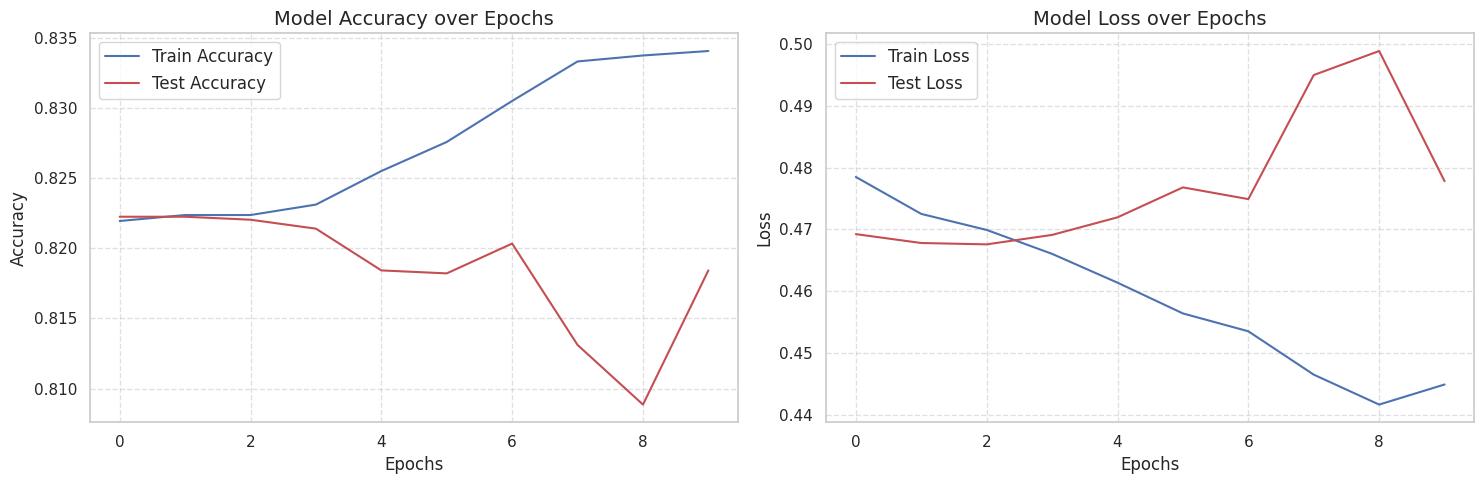

In [25]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot([m['accuracy'] for m in train_metrics_history], 'b-', label='Train Accuracy')
plt.plot([m['accuracy'] for m in test_metrics_history], 'r-', label='Test Accuracy')
plt.title('Model Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot([m['loss'] for m in train_metrics_history], 'b-', label='Train Loss')
plt.plot([m['loss'] for m in test_metrics_history], 'r-', label='Test Loss')
plt.title('Model Loss over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

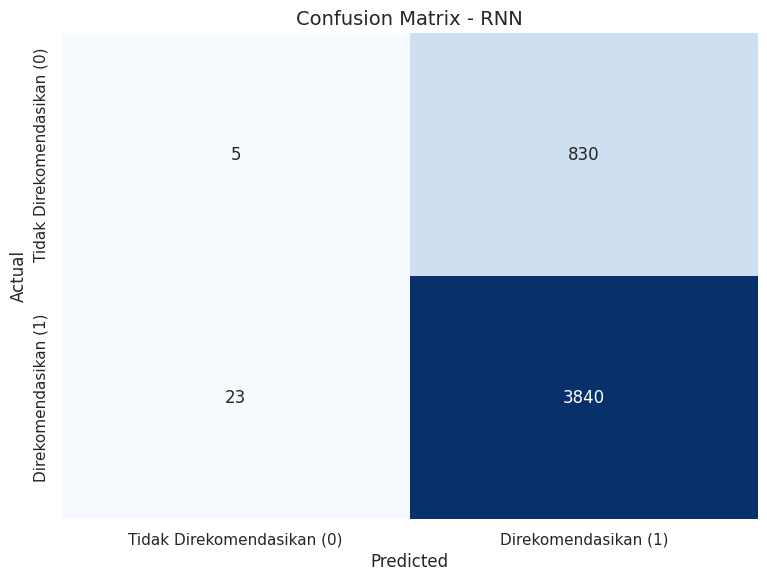

In [26]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - RNN', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks([0.5, 1.5], ['Tidak Direkomendasikan (0)', 'Direkomendasikan (1)'])
plt.yticks([0.5, 1.5], ['Tidak Direkomendasikan (0)', 'Direkomendasikan (1)'])
plt.show()

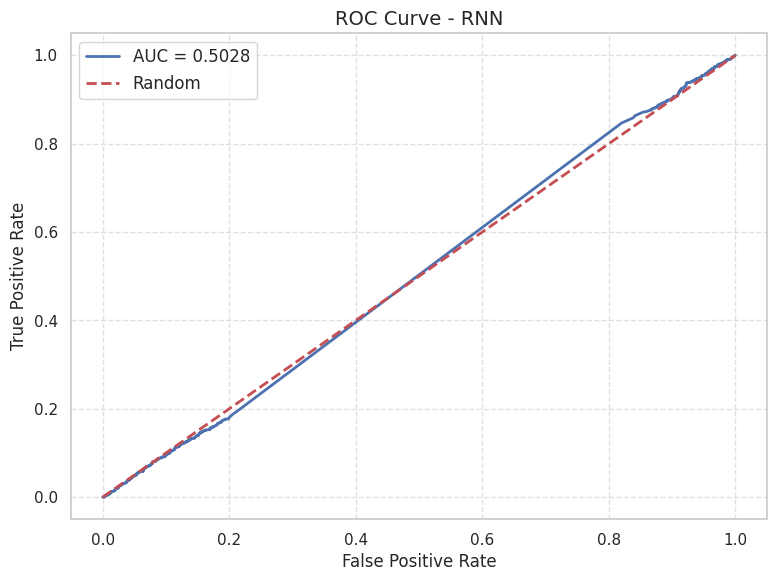

In [27]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(final_y, final_preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {final_test_metrics["auc"]:.4f}')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - RNN', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [28]:
# Simpan model
torch.save(model.state_dict(), 'rnn_model_pytorch.pt')
print("Model RNN PyTorch telah disimpan sebagai 'rnn_model_pytorch.pt'")

# Simpan metric history untuk perbandingan nantinya
import pickle
with open('rnn_metrics_history.pkl', 'wb') as f:
    pickle.dump({'train': train_metrics_history, 'test': test_metrics_history,
                 'final_metrics': final_test_metrics, 'cm': final_cm}, f)
print("Metrics history disimpan untuk perbandingan model")

Model RNN PyTorch telah disimpan sebagai 'rnn_model_pytorch.pt'
Metrics history disimpan untuk perbandingan model


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import seaborn as sns
import time

# Set seed untuk reproduksibilitas
torch.manual_seed(42)
np.random.seed(42)

# Muat data yang telah diproses sebelumnya
print("Loading processed data...")
X_train_sequences = np.load('X_train_sequences.npy')
X_test_sequences = np.load('X_test_sequences.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Tentukan parameter model (gunakan parameter yang sama dengan RNN untuk perbandingan adil)
vocab_size = 10000
embedding_dim = 100
hidden_dim = 128
output_dim = 1
num_layers = 2
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 10
max_seq_length = 100

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

Loading processed data...
Menggunakan device: cuda


In [30]:
# Konversi data menjadi format PyTorch
X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

# Buat dataset dan dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [31]:
# Definisikan model LSTM
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()

        # Layer embedding untuk mengkonversi indeks kata menjadi vektor embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Layer LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                           batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)

        # Layer fully connected untuk output
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Layer dropout untuk mencegah overfitting
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, text):
        # text shape: [batch size, max_seq_length]

        # Konversi indeks kata menjadi embedding
        embedded = self.embedding(text)
        # embedded shape: [batch size, max_seq_length, embedding_dim]

        # Proses sequence dengan LSTM
        # output berisi semua hidden states, (h_n, c_n) adalah tuple dari hidden state dan cell state terakhir
        output, (hidden, cell) = self.lstm(embedded)
        # output shape: [batch size, max_seq_length, hidden_dim]
        # hidden shape: [num_layers, batch size, hidden_dim]
        # cell shape: [num_layers, batch size, hidden_dim]

        # Menggunakan hidden state terakhir untuk klasifikasi
        hidden = hidden[-1, :, :]  # Ambil hidden state dari layer terakhir
        # hidden shape: [batch size, hidden_dim]

        # Terapkan dropout
        hidden = self.dropout(hidden)

        # Linear layer untuk klasifikasi
        return self.fc(hidden)

In [32]:
# Inisialisasi model LSTM
lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate)
lstm_model.to(device)

# Definisikan loss function dan optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Cetak ringkasan model
print(lstm_model)

LSTMModel(
  (embedding): Embedding(10000, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [33]:
# Fungsi training dan evaluasi yang sama dengan RNN
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_y = []

    for batch in train_loader:
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        all_preds.extend(torch.sigmoid(predictions).cpu().detach().numpy())
        all_y.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_y = np.array(all_y)
    binary_preds = (all_preds > 0.5).astype(int)

    train_metrics = {
        'loss': epoch_loss / len(train_loader),
        'accuracy': accuracy_score(all_y, binary_preds),
        'precision': precision_score(all_y, binary_preds),
        'recall': recall_score(all_y, binary_preds),
        'f1': f1_score(all_y, binary_preds),
        'auc': roc_auc_score(all_y, all_preds)
    }

    return train_metrics

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_y = []

    with torch.no_grad():
        for batch in test_loader:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()

            all_preds.extend(torch.sigmoid(predictions).cpu().detach().numpy())
            all_y.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_y = np.array(all_y)
    binary_preds = (all_preds > 0.5).astype(int)

    test_metrics = {
        'loss': epoch_loss / len(test_loader),
        'accuracy': accuracy_score(all_y, binary_preds),
        'precision': precision_score(all_y, binary_preds),
        'recall': recall_score(all_y, binary_preds),
        'f1': f1_score(all_y, binary_preds),
        'auc': roc_auc_score(all_y, all_preds)
    }

    cm = confusion_matrix(all_y, binary_preds)

    return test_metrics, cm, all_preds, all_y

In [34]:
# Training loop
lstm_train_metrics_history = []
lstm_test_metrics_history = []

print(f"\nMemulai training model LSTM dengan PyTorch untuk {num_epochs} epochs...")
start_time = time.time()

for epoch in range(num_epochs):
    train_metrics = train_model(lstm_model, train_loader, optimizer, criterion, device)
    lstm_train_metrics_history.append(train_metrics)

    test_metrics, confusion_mat, test_preds, test_y = evaluate_model(lstm_model, test_loader, criterion, device)
    lstm_test_metrics_history.append(test_metrics)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_metrics['loss']:.4f} | "
          f"Train Acc: {train_metrics['accuracy']:.4f} | "
          f"Test Loss: {test_metrics['loss']:.4f} | "
          f"Test Acc: {test_metrics['accuracy']:.4f}")

training_time = time.time() - start_time
print(f"\nTraining selesai dalam {training_time:.2f} detik")


Memulai training model LSTM dengan PyTorch untuk 10 epochs...
Epoch 1/10 | Train Loss: 0.4741 | Train Acc: 0.8204 | Test Loss: 0.4675 | Test Acc: 0.8223
Epoch 2/10 | Train Loss: 0.4700 | Train Acc: 0.8224 | Test Loss: 0.4695 | Test Acc: 0.8223
Epoch 3/10 | Train Loss: 0.4685 | Train Acc: 0.8221 | Test Loss: 0.4680 | Test Acc: 0.8223
Epoch 4/10 | Train Loss: 0.4129 | Train Acc: 0.8290 | Test Loss: 0.3262 | Test Acc: 0.8593
Epoch 5/10 | Train Loss: 0.2775 | Train Acc: 0.8822 | Test Loss: 0.2802 | Test Acc: 0.8802
Epoch 6/10 | Train Loss: 0.2270 | Train Acc: 0.9064 | Test Loss: 0.2759 | Test Acc: 0.8889
Epoch 7/10 | Train Loss: 0.1958 | Train Acc: 0.9212 | Test Loss: 0.2666 | Test Acc: 0.8914
Epoch 8/10 | Train Loss: 0.1719 | Train Acc: 0.9308 | Test Loss: 0.2786 | Test Acc: 0.8897
Epoch 9/10 | Train Loss: 0.1475 | Train Acc: 0.9429 | Test Loss: 0.2865 | Test Acc: 0.8874
Epoch 10/10 | Train Loss: 0.1258 | Train Acc: 0.9526 | Test Loss: 0.2931 | Test Acc: 0.8940

Training selesai dalam 21

In [35]:
# Final evaluation and metrics
lstm_final_metrics, lstm_final_cm, lstm_final_preds, lstm_final_y = evaluate_model(lstm_model, test_loader, criterion, device)

print("\nMetrik Evaluasi Akhir (LSTM):")
print(f"Accuracy: {lstm_final_metrics['accuracy']:.4f}")
print(f"Precision: {lstm_final_metrics['precision']:.4f}")
print(f"Recall: {lstm_final_metrics['recall']:.4f}")
print(f"F1 Score: {lstm_final_metrics['f1']:.4f}")
print(f"AUC-ROC: {lstm_final_metrics['auc']:.4f}")


Metrik Evaluasi Akhir (LSTM):
Accuracy: 0.8940
Precision: 0.9351
Recall: 0.9361
F1 Score: 0.9356
AUC-ROC: 0.9219


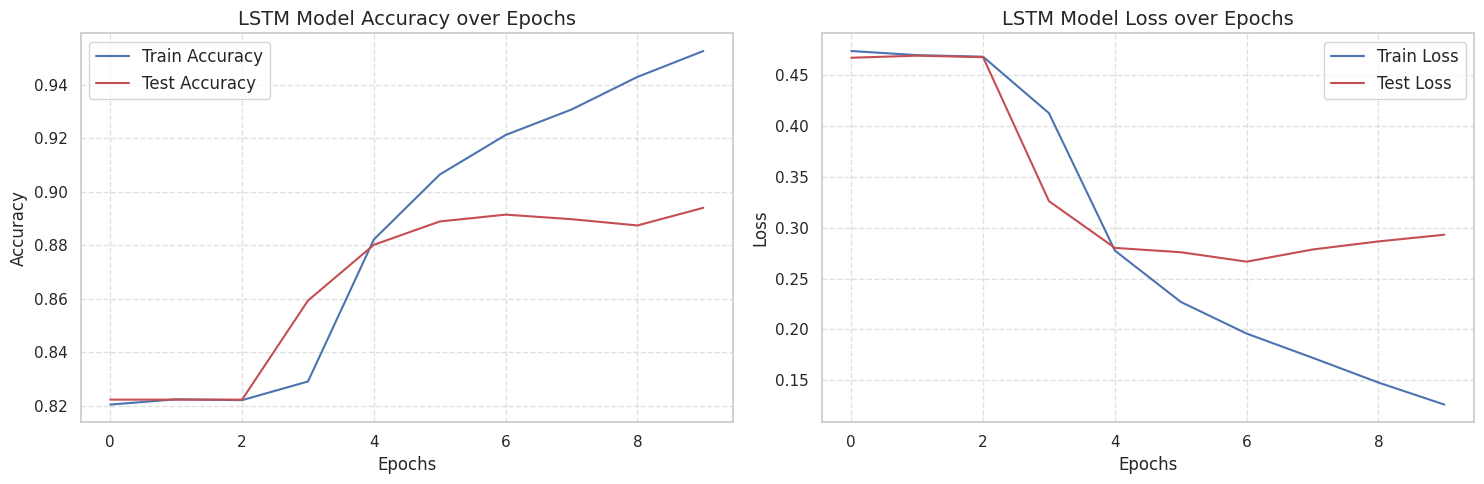

In [36]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot([m['accuracy'] for m in lstm_train_metrics_history], 'b-', label='Train Accuracy')
plt.plot([m['accuracy'] for m in lstm_test_metrics_history], 'r-', label='Test Accuracy')
plt.title('LSTM Model Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot([m['loss'] for m in lstm_train_metrics_history], 'b-', label='Train Loss')
plt.plot([m['loss'] for m in lstm_test_metrics_history], 'r-', label='Test Loss')
plt.title('LSTM Model Loss over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

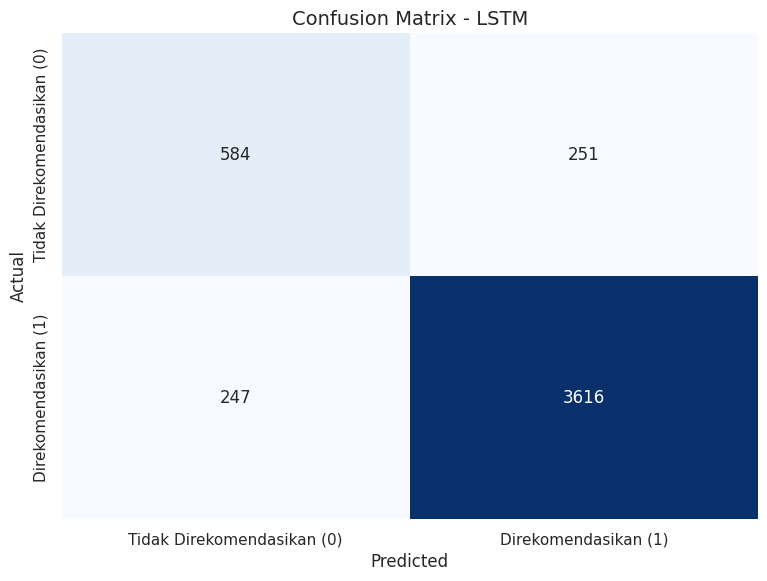

In [37]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_final_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - LSTM', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks([0.5, 1.5], ['Tidak Direkomendasikan (0)', 'Direkomendasikan (1)'])
plt.yticks([0.5, 1.5], ['Tidak Direkomendasikan (0)', 'Direkomendasikan (1)'])
plt.show()

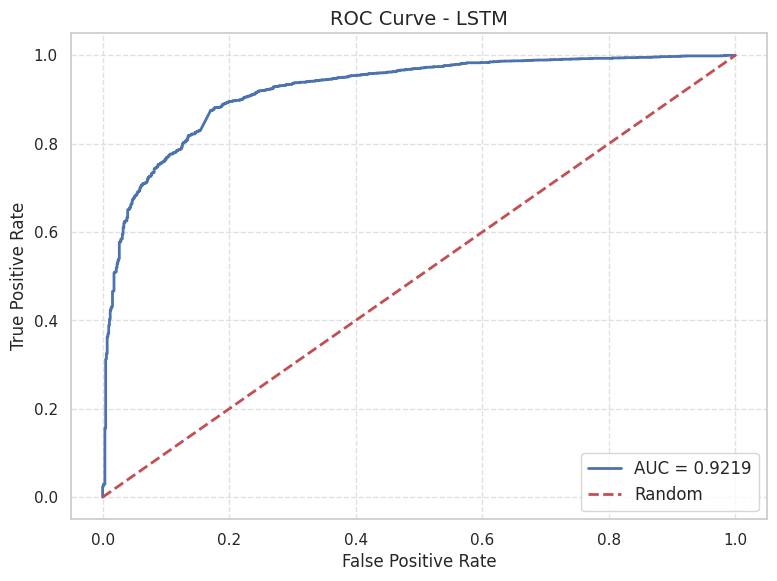

In [38]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(lstm_final_y, lstm_final_preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {lstm_final_metrics["auc"]:.4f}')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - LSTM', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [39]:
# Simpan model
torch.save(lstm_model.state_dict(), 'lstm_model_pytorch.pt')
print("Model LSTM PyTorch telah disimpan sebagai 'lstm_model_pytorch.pt'")

# Simpan metric history untuk perbandingan nantinya
import pickle
with open('lstm_metrics_history.pkl', 'wb') as f:
    pickle.dump({'train': lstm_train_metrics_history, 'test': lstm_test_metrics_history,
                 'final_metrics': lstm_final_metrics, 'cm': lstm_final_cm}, f)
print("Metrics history disimpan untuk perbandingan model")

Model LSTM PyTorch telah disimpan sebagai 'lstm_model_pytorch.pt'
Metrics history disimpan untuk perbandingan model


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import seaborn as sns
import time

# Set seed untuk reproduksibilitas
torch.manual_seed(42)
np.random.seed(42)

# Muat data yang telah diproses sebelumnya
print("Loading processed data...")
X_train_sequences = np.load('X_train_sequences.npy')
X_test_sequences = np.load('X_test_sequences.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Tentukan parameter model (gunakan parameter yang sama untuk perbandingan adil)
vocab_size = 10000
embedding_dim = 100
hidden_dim = 128
output_dim = 1
num_layers = 2
dropout_rate = 0.3
batch_size = 64
learning_rate = 0.001
num_epochs = 10
max_seq_length = 100

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

Loading processed data...
Menggunakan device: cuda


In [41]:
# Konversi data menjadi format PyTorch
X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

# Buat dataset dan dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [42]:
# Definisikan model GRU
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate):
        super(GRUModel, self).__init__()

        # Layer embedding untuk mengkonversi indeks kata menjadi vektor embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Layer GRU
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)

        # Layer fully connected untuk output
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Layer dropout untuk mencegah overfitting
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, text):
        # text shape: [batch size, max_seq_length]

        # Konversi indeks kata menjadi embedding
        embedded = self.embedding(text)
        # embedded shape: [batch size, max_seq_length, embedding_dim]

        # Proses sequence dengan GRU
        output, hidden = self.gru(embedded)
        # output shape: [batch size, max_seq_length, hidden_dim]
        # hidden shape: [num_layers, batch size, hidden_dim]

        # Menggunakan hidden state terakhir untuk klasifikasi
        hidden = hidden[-1, :, :]  # Ambil hidden state dari layer terakhir
        # hidden shape: [batch size, hidden_dim]

        # Terapkan dropout
        hidden = self.dropout(hidden)

        # Linear layer untuk klasifikasi
        return self.fc(hidden)

In [43]:
# Inisialisasi model GRU
gru_model = GRUModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate)
gru_model.to(device)

# Definisikan loss function dan optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate)

# Cetak ringkasan model
print(gru_model)

GRUModel(
  (embedding): Embedding(10000, 100)
  (gru): GRU(100, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [44]:
# Fungsi training dan evaluasi yang sama seperti sebelumnya
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_y = []

    for batch in train_loader:
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        all_preds.extend(torch.sigmoid(predictions).cpu().detach().numpy())
        all_y.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_y = np.array(all_y)
    binary_preds = (all_preds > 0.5).astype(int)

    train_metrics = {
        'loss': epoch_loss / len(train_loader),
        'accuracy': accuracy_score(all_y, binary_preds),
        'precision': precision_score(all_y, binary_preds),
        'recall': recall_score(all_y, binary_preds),
        'f1': f1_score(all_y, binary_preds),
        'auc': roc_auc_score(all_y, all_preds)
    }

    return train_metrics

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_y = []

    with torch.no_grad():
        for batch in test_loader:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()

            all_preds.extend(torch.sigmoid(predictions).cpu().detach().numpy())
            all_y.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_y = np.array(all_y)
    binary_preds = (all_preds > 0.5).astype(int)

    test_metrics = {
        'loss': epoch_loss / len(test_loader),
        'accuracy': accuracy_score(all_y, binary_preds),
        'precision': precision_score(all_y, binary_preds),
        'recall': recall_score(all_y, binary_preds),
        'f1': f1_score(all_y, binary_preds),
        'auc': roc_auc_score(all_y, all_preds)
    }

    cm = confusion_matrix(all_y, binary_preds)

    return test_metrics, cm, all_preds, all_y

In [45]:
# Training loop
gru_train_metrics_history = []
gru_test_metrics_history = []

print(f"\nMemulai training model GRU dengan PyTorch untuk {num_epochs} epochs...")
start_time = time.time()

for epoch in range(num_epochs):
    train_metrics = train_model(gru_model, train_loader, optimizer, criterion, device)
    gru_train_metrics_history.append(train_metrics)

    test_metrics, confusion_mat, test_preds, test_y = evaluate_model(gru_model, test_loader, criterion, device)
    gru_test_metrics_history.append(test_metrics)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_metrics['loss']:.4f} | "
          f"Train Acc: {train_metrics['accuracy']:.4f} | "
          f"Test Loss: {test_metrics['loss']:.4f} | "
          f"Test Acc: {test_metrics['accuracy']:.4f}")

training_time = time.time() - start_time
print(f"\nTraining selesai dalam {training_time:.2f} detik")


Memulai training model GRU dengan PyTorch untuk 10 epochs...
Epoch 1/10 | Train Loss: 0.4495 | Train Acc: 0.8281 | Test Loss: 0.3443 | Test Acc: 0.8546
Epoch 2/10 | Train Loss: 0.2796 | Train Acc: 0.8810 | Test Loss: 0.2534 | Test Acc: 0.8942
Epoch 3/10 | Train Loss: 0.2150 | Train Acc: 0.9097 | Test Loss: 0.2460 | Test Acc: 0.8997
Epoch 4/10 | Train Loss: 0.1763 | Train Acc: 0.9303 | Test Loss: 0.2398 | Test Acc: 0.9010
Epoch 5/10 | Train Loss: 0.1365 | Train Acc: 0.9481 | Test Loss: 0.2830 | Test Acc: 0.8978
Epoch 6/10 | Train Loss: 0.1034 | Train Acc: 0.9639 | Test Loss: 0.3093 | Test Acc: 0.8976
Epoch 7/10 | Train Loss: 0.0786 | Train Acc: 0.9733 | Test Loss: 0.3404 | Test Acc: 0.8878
Epoch 8/10 | Train Loss: 0.0532 | Train Acc: 0.9840 | Test Loss: 0.3487 | Test Acc: 0.8948
Epoch 9/10 | Train Loss: 0.0406 | Train Acc: 0.9883 | Test Loss: 0.4408 | Test Acc: 0.8865
Epoch 10/10 | Train Loss: 0.0362 | Train Acc: 0.9895 | Test Loss: 0.4783 | Test Acc: 0.8923

Training selesai dalam 16.

In [46]:
# Final evaluation and metrics
gru_final_metrics, gru_final_cm, gru_final_preds, gru_final_y = evaluate_model(gru_model, test_loader, criterion, device)

print("\nMetrik Evaluasi Akhir (GRU):")
print(f"Accuracy: {gru_final_metrics['accuracy']:.4f}")
print(f"Precision: {gru_final_metrics['precision']:.4f}")
print(f"Recall: {gru_final_metrics['recall']:.4f}")
print(f"F1 Score: {gru_final_metrics['f1']:.4f}")
print(f"AUC-ROC: {gru_final_metrics['auc']:.4f}")


Metrik Evaluasi Akhir (GRU):
Accuracy: 0.8923
Precision: 0.9242
Recall: 0.9467
F1 Score: 0.9353
AUC-ROC: 0.9184


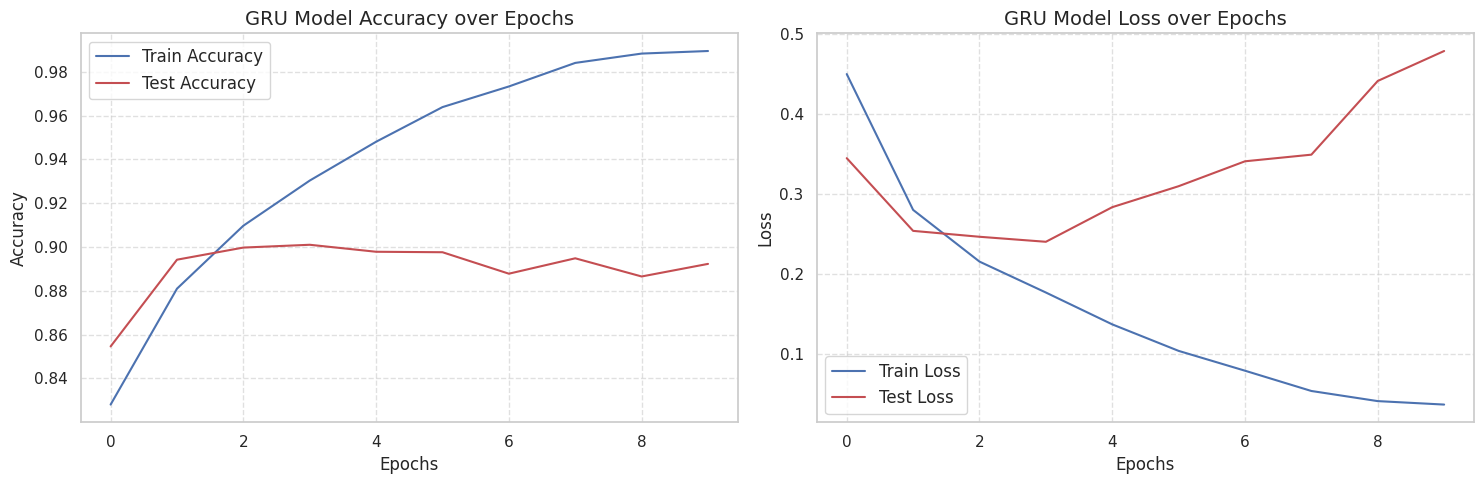

In [47]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot([m['accuracy'] for m in gru_train_metrics_history], 'b-', label='Train Accuracy')
plt.plot([m['accuracy'] for m in gru_test_metrics_history], 'r-', label='Test Accuracy')
plt.title('GRU Model Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot([m['loss'] for m in gru_train_metrics_history], 'b-', label='Train Loss')
plt.plot([m['loss'] for m in gru_test_metrics_history], 'r-', label='Test Loss')
plt.title('GRU Model Loss over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

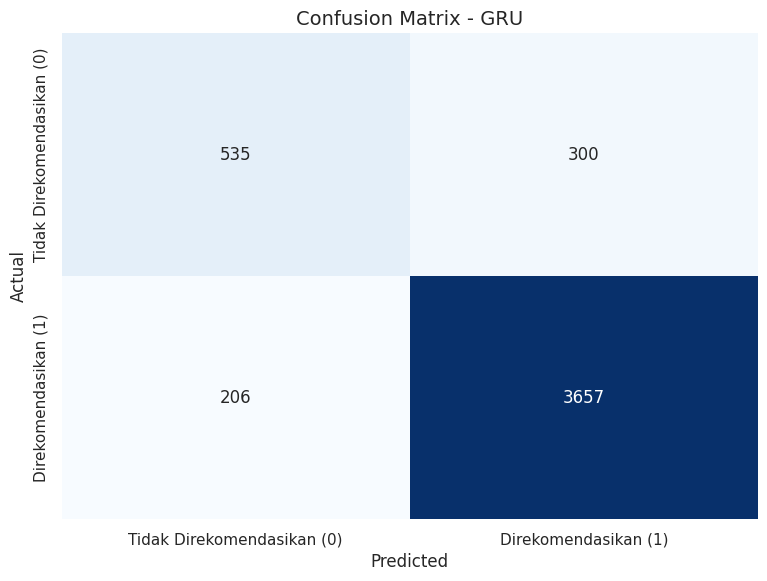

In [48]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(gru_final_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - GRU', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks([0.5, 1.5], ['Tidak Direkomendasikan (0)', 'Direkomendasikan (1)'])
plt.yticks([0.5, 1.5], ['Tidak Direkomendasikan (0)', 'Direkomendasikan (1)'])
plt.show()

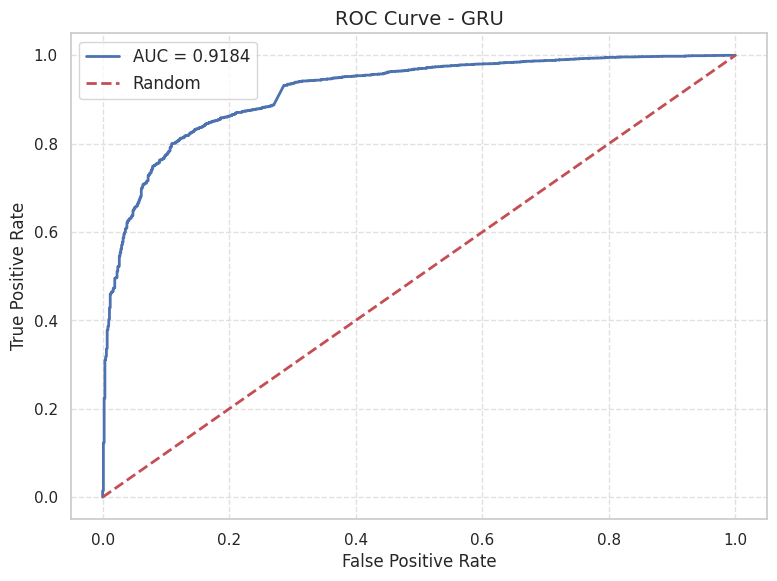

In [49]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(gru_final_y, gru_final_preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {gru_final_metrics["auc"]:.4f}')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - GRU', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [50]:
# Simpan model
torch.save(gru_model.state_dict(), 'gru_model_pytorch.pt')
print("Model GRU PyTorch telah disimpan sebagai 'gru_model_pytorch.pt'")

# Simpan metric history untuk perbandingan nantinya
import pickle
with open('gru_metrics_history.pkl', 'wb') as f:
    pickle.dump({'train': gru_train_metrics_history, 'test': gru_test_metrics_history,
                 'final_metrics': gru_final_metrics, 'cm': gru_final_cm}, f)
print("Metrics history disimpan untuk perbandingan model")

Model GRU PyTorch telah disimpan sebagai 'gru_model_pytorch.pt'
Metrics history disimpan untuk perbandingan model


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

# Set style untuk visualisasi
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

In [52]:
# Load metrics history dari ketiga model
with open('rnn_metrics_history.pkl', 'rb') as f:
    rnn_history = pickle.load(f)

with open('lstm_metrics_history.pkl', 'rb') as f:
    lstm_history = pickle.load(f)

with open('gru_metrics_history.pkl', 'rb') as f:
    gru_history = pickle.load(f)

## Perbandingan Metrik Evaluasi

In [53]:
# Buat DataFrame untuk perbandingan metrik akhir
final_metrics = pd.DataFrame({
    'Model': ['RNN', 'LSTM', 'GRU'],
    'Accuracy': [
        rnn_history['final_metrics']['accuracy'],
        lstm_history['final_metrics']['accuracy'],
        gru_history['final_metrics']['accuracy']
    ],
    'Precision': [
        rnn_history['final_metrics']['precision'],
        lstm_history['final_metrics']['precision'],
        gru_history['final_metrics']['precision']
    ],
    'Recall': [
        rnn_history['final_metrics']['recall'],
        lstm_history['final_metrics']['recall'],
        gru_history['final_metrics']['recall']
    ],
    'F1 Score': [
        rnn_history['final_metrics']['f1'],
        lstm_history['final_metrics']['f1'],
        gru_history['final_metrics']['f1']
    ],
    'AUC-ROC': [
        rnn_history['final_metrics']['auc'],
        lstm_history['final_metrics']['auc'],
        gru_history['final_metrics']['auc']
    ]
})

# Tampilkan tabel perbandingan
print("Perbandingan Metrik Evaluasi Akhir:")
final_metrics.set_index('Model')

Perbandingan Metrik Evaluasi Akhir:


,Accuracy,Precision,Recall,F1 Score,AUC-ROC
Model,,,,,
RNN,0.818433,0.822270,0.994046,0.900035,0.502762
LSTM,0.893997,0.935092,0.936060,0.935576,0.921897
GRU,0.892295,0.924185,0.946674,0.935294,0.918442


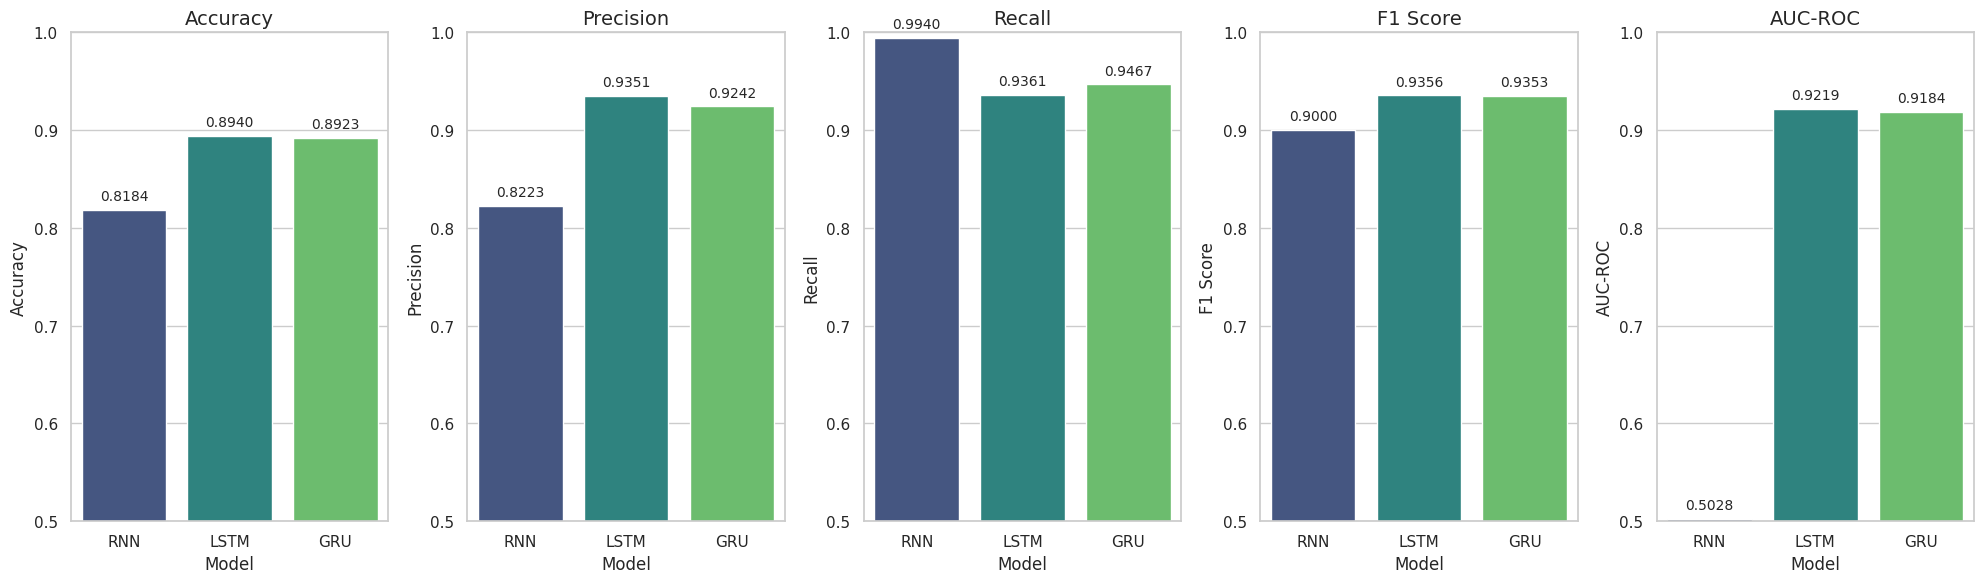

In [54]:
# Visualisasi perbandingan metrik evaluasi
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
models = ['RNN', 'LSTM', 'GRU']

fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x='Model', y=metric, data=final_metrics, ax=ax, palette='viridis')
    ax.set_title(f'{metric}', fontsize=14)
    ax.set_ylim(0.5, 1.0)  # Sesuaikan range Y untuk fokus pada perbedaan

    # Tambahkan nilai di atas bar
    for j, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 0.01,
                f'{height:.4f}',
                ha="center", fontsize=10)

plt.tight_layout()
plt.show()

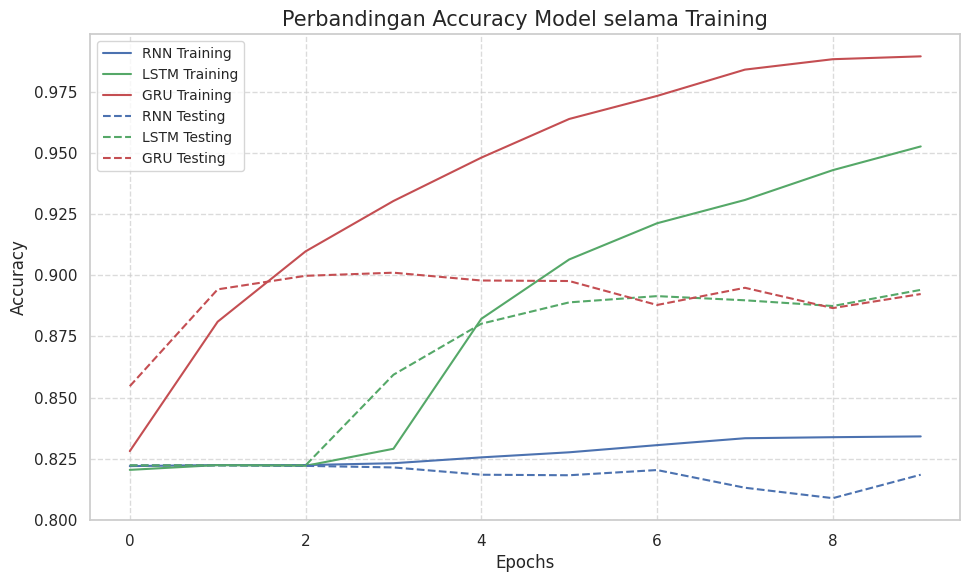

In [55]:
# Plot perbandingan training dan test accuracy
plt.figure(figsize=(10, 6))

# Training accuracy
plt.plot([m['accuracy'] for m in rnn_history['train']], 'b-', label='RNN Training')
plt.plot([m['accuracy'] for m in lstm_history['train']], 'g-', label='LSTM Training')
plt.plot([m['accuracy'] for m in gru_history['train']], 'r-', label='GRU Training')

# Test accuracy
plt.plot([m['accuracy'] for m in rnn_history['test']], 'b--', label='RNN Testing')
plt.plot([m['accuracy'] for m in lstm_history['test']], 'g--', label='LSTM Testing')
plt.plot([m['accuracy'] for m in gru_history['test']], 'r--', label='GRU Testing')

plt.title('Perbandingan Accuracy Model selama Training', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.show()

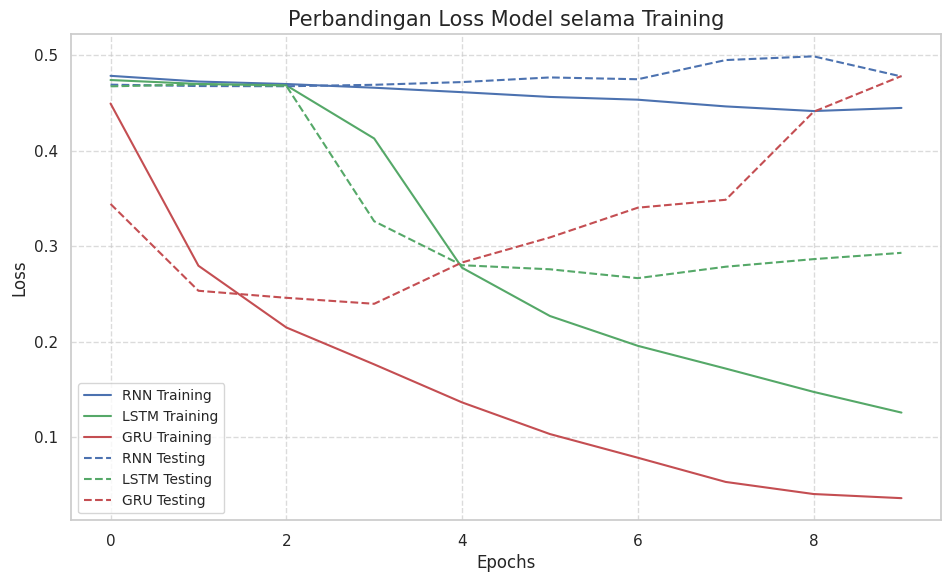

In [56]:
# Plot perbandingan training dan test loss
plt.figure(figsize=(10, 6))

# Training loss
plt.plot([m['loss'] for m in rnn_history['train']], 'b-', label='RNN Training')
plt.plot([m['loss'] for m in lstm_history['train']], 'g-', label='LSTM Training')
plt.plot([m['loss'] for m in gru_history['train']], 'r-', label='GRU Training')

# Test loss
plt.plot([m['loss'] for m in rnn_history['test']], 'b--', label='RNN Testing')
plt.plot([m['loss'] for m in lstm_history['test']], 'g--', label='LSTM Testing')
plt.plot([m['loss'] for m in gru_history['test']], 'r--', label='GRU Testing')

plt.title('Perbandingan Loss Model selama Training', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.show()

In [57]:
# Definisikan fungsi untuk visualisasi confusion matrix dengan persentase
def plot_confusion_matrix_with_percentages(cm, title):
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xticklabels(['Tidak Direkomendasikan (0)', 'Direkomendasikan (1)'])
    ax.set_yticklabels(['Tidak Direkomendasikan (0)', 'Direkomendasikan (1)'])
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    return fig, ax

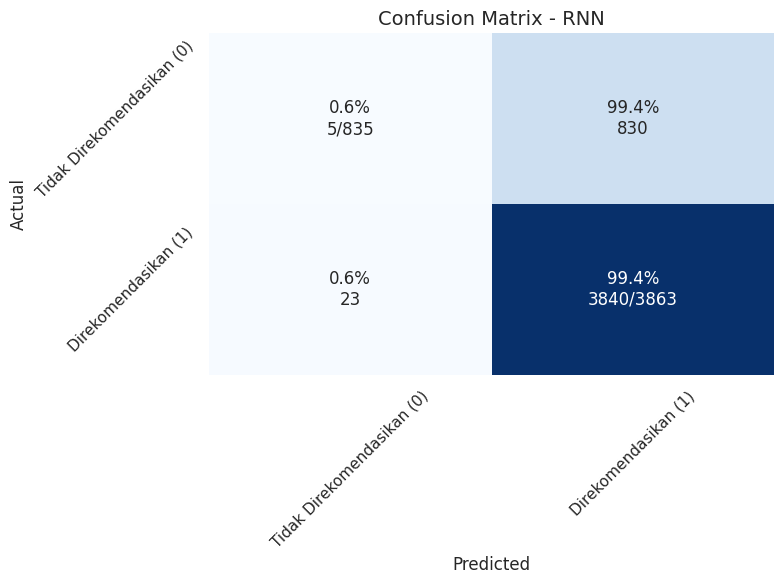

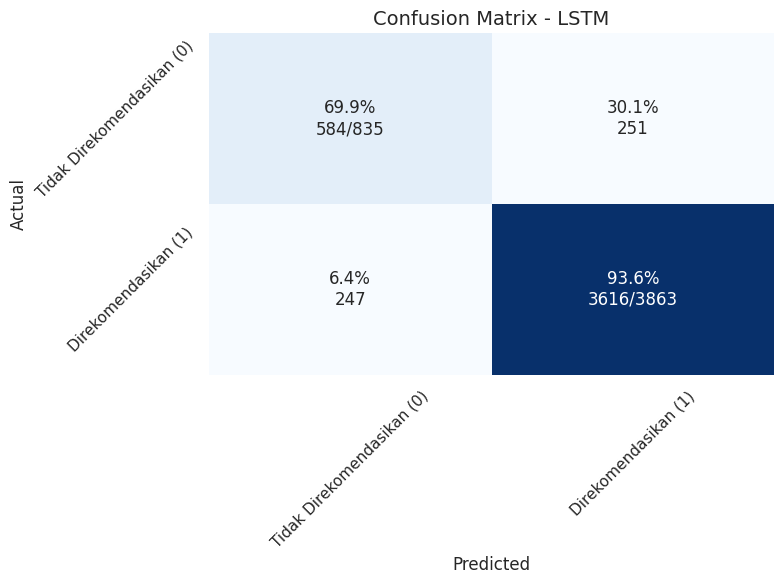

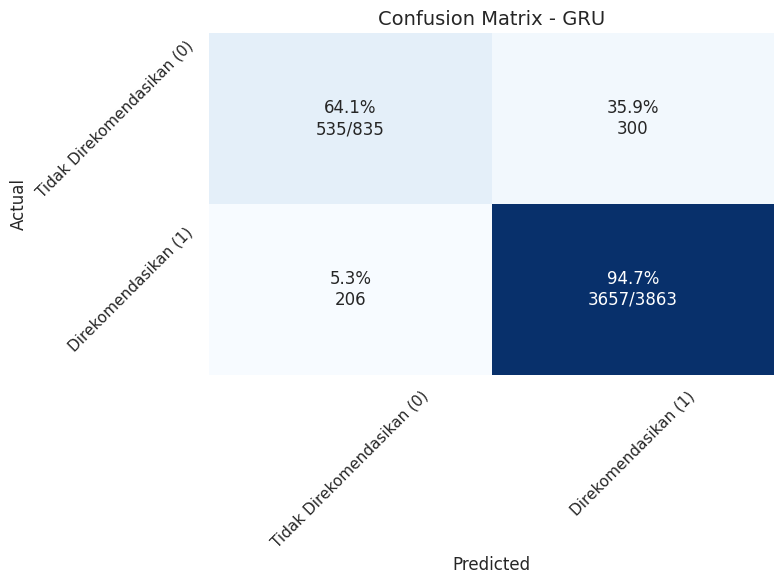

In [58]:
# Plot confusion matrix untuk masing-masing model
plot_confusion_matrix_with_percentages(rnn_history['cm'], 'Confusion Matrix - RNN')
plt.show()

plot_confusion_matrix_with_percentages(lstm_history['cm'], 'Confusion Matrix - LSTM')
plt.show()

plot_confusion_matrix_with_percentages(gru_history['cm'], 'Confusion Matrix - GRU')
plt.show()

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC

# Muat data yang telah diproses
X_train_sequences = np.load('X_train_sequences.npy')
X_test_sequences = np.load('X_test_sequences.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Parameter model
vocab_size = 10000
embedding_dim = 100
hidden_dim = 128
output_dim = 1
num_layers = 2
dropout_rate = 0.3

In [60]:
# Model RNN dengan TensorFlow/Keras
def create_rnn_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
        SimpleRNN(hidden_dim, return_sequences=True),
        Dropout(dropout_rate),
        SimpleRNN(hidden_dim),
        Dropout(dropout_rate),
        Dense(output_dim, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(), Recall(), AUC()]
    )

    return model

# Model LSTM dengan TensorFlow/Keras
def create_lstm_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
        LSTM(hidden_dim, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(hidden_dim),
        Dropout(dropout_rate),
        Dense(output_dim, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(), Recall(), AUC()]
    )

    return model

# Model GRU dengan TensorFlow/Keras
def create_gru_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
        GRU(hidden_dim, return_sequences=True),
        Dropout(dropout_rate),
        GRU(hidden_dim),
        Dropout(dropout_rate),
        Dense(output_dim, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(), Recall(), AUC()]
    )

    return model